# Model Selection for Neural Networks

## Setup

In [14]:
import os

## adapt this directory to your needs
base_dir = '../'
notebook_dir = os.path.join(base_dir, 'Exercise')
data_dir = os.path.join(base_dir, 'DataSets')

In [15]:
import random

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score

import tensorflow as tf

from pyMLaux import show_img_data, evaluate_classification_result

## Load Simple Digit Recognition Data

In [16]:
dig_train_raw = pd.read_csv(os.path.join(data_dir,'Digits_training.csv'), sep=',')
dig_train = {'data': np.array(dig_train_raw.iloc[:, :-1]),
             'target': np.array(dig_train_raw.iloc[:, -1]),
             'feature_names': dig_train_raw.columns[:-1],
             'target_names': [str(i) for i in range(0, 10)]}

In [17]:
dig_test_raw = pd.read_csv(os.path.join(data_dir, 'Digits_test.csv'), sep=',')
dig_test = {'data': np.array(dig_test_raw.iloc[:, :-1]),
            'target': np.array(dig_test_raw.iloc[:, -1]),
            'feature_names': dig_test_raw.columns[:-1],
            'target_names': [str(i) for i in range(0, 10)]}

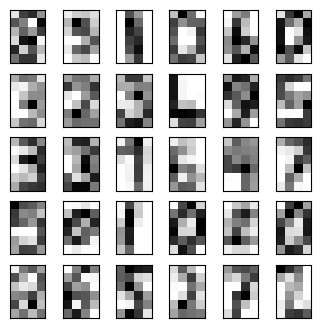

In [18]:
show_img_data(dig_train['data'].reshape((dig_train['data'].shape[0], 6, 4, 1)), figsize=(4, 4),
              interpolation=None)

In [19]:
dig_train['target'][range(0, 30)].reshape(5, 6)

array([[8, 5, 1, 0, 6, 0],
       [3, 2, 3, 4, 9, 5],
       [3, 3, 1, 6, 4, 7],
       [5, 0, 1, 0, 2, 0],
       [2, 6, 5, 2, 7, 2]])

In [20]:
X_train, X_val, y_train, y_val = train_test_split(dig_train['data'], dig_train['target'],
                                                  test_size=0.3, random_state=4232)

## Functions for Hyperparameter/Architecture Selection

In [ ]:
def create_hyperparams(n, default_lr=0.001):
    df = pd.DataFrame(index=range(n),
                      columns=['no_hidden_layers', 'hidden_layers', 'activation', 'dropout', 'lr', 'epochs'])

    for i in range(n):
        df.loc[i, 'lr'] = default_lr * 5.**random.uniform(-1., 1.)
        df.loc[i, 'epochs'] = random.sample([16, 32, 64, 128], 1)[0]

        no_layers = random.randint(0, 4)
        df.loc[i, 'no_hidden_layers'] = no_layers
        df.loc[i, 'hidden_layers'] = [int(random.sample([8, 16, 32, 64], 1)[0]) for i in range(no_layers)]
        df.loc[i, 'dropout'] = random.sample([0.0, 0.25, 0.5], 1)[0]
        df.loc[i, 'activation'] = random.sample(['sigmoid', 'relu', 'elu'], 1)[0]

    return(df)

In [22]:
def create_network(hp, no_inputs, no_outputs, output_activation='softmax', **kwargs):
    hidden_layers = hp['hidden_layers']

    dropout = hp['dropout']
    hidden_activation = hp['activation']

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(no_inputs, )))

    for cl in hidden_layers:
        model.add(tf.keras.layers.Dense(cl, activation=hidden_activation))
        if dropout > 0:
            model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(no_outputs, activation=output_activation))

    opt = tf.keras.optimizers.Adam(learning_rate=hp['lr'])

    model.compile(optimizer=opt, **kwargs)

    return(model)

In [ ]:
df = create_hyperparams(10)
df

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs
0,1,[32],sigmoid,0.5,0.000433,32
1,4,"[32, 64, 8, 16]",sigmoid,0.25,0.003838,32
2,0,[],sigmoid,0.5,0.003609,64
3,4,"[16, 8, 8, 16]",elu,0.5,0.000697,32
4,1,[8],sigmoid,0.5,0.00038,64
...,...,...,...,...,...,...
995,2,"[32, 8]",elu,0.0,0.000719,32
996,4,"[8, 8, 32, 8]",relu,0.25,0.000812,128
997,4,"[16, 64, 32, 8]",elu,0.25,0.000504,32
998,4,"[8, 64, 64, 64]",relu,0.25,0.000237,128


In [13]:
model = create_network(df.iloc[1, :], no_inputs=24, no_outputs=10, loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,250 (8.79 KB)

 Trainable params: 2,250 (8.79 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def find_best(df, crit='ACC'):
    index = np.where(df[crit] == np.amax(df[crit]))[0]
    return(df.iloc[list(index), :])

## Perform Model Selection and Determine Best Model

In [16]:
random.seed(4232)
batch_size = 32
no_models = 25

In [17]:
model_sel = create_hyperparams(no_models)
model_sel['ACC'] = -1.

In [18]:
model_sel

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
0,3,"[16, 16, 8]",sigmoid,0.25,0.000845,64,-1.0
1,3,"[16, 16, 8]",elu,0.5,0.00249,16,-1.0
2,3,"[32, 32, 64]",relu,0.5,0.000726,128,-1.0
3,3,"[32, 64, 16]",elu,0.5,0.004028,16,-1.0
4,4,"[8, 16, 8, 8]",sigmoid,0.5,0.002493,128,-1.0
5,2,"[64, 16]",elu,0.5,0.000207,64,-1.0
6,1,[32],relu,0.0,0.000927,128,-1.0
7,3,"[32, 32, 16]",relu,0.5,0.002541,16,-1.0
8,4,"[64, 8, 8, 64]",sigmoid,0.25,0.000518,128,-1.0
9,4,"[64, 16, 16, 8]",relu,0.25,0.004939,16,-1.0


In [19]:
pbar = tf.keras.utils.Progbar(target=no_models, stateful_metrics=[]) ## progress bar
for i in range(no_models):
    model = create_network(model_sel.iloc[i], no_inputs=X_train.shape[1],
                           no_outputs=10, loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

    history = model.fit(x=X_train, y=y_train,
                        epochs=model_sel['epochs'][i],
                        batch_size=batch_size,
                        verbose=0)

    pred = model.predict(x=X_val, verbose=0)
    predC = np.argmax(pred, axis=1)

    model_sel.loc[i, 'ACC'] = accuracy_score(y_val, predC)

    tf.keras.backend.clear_session()
    pbar.update(i, finalize=False)
pbar.update(no_models, finalize=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 413s 16s/step


In [20]:
model_sel.sort_values(by='ACC', ascending=False).head(10)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
21,3,"[64, 64, 64]",relu,0.0,0.001209,16,0.923333
23,2,"[32, 32]",relu,0.25,0.001137,128,0.907778
22,3,"[64, 8, 32]",elu,0.25,0.004396,128,0.903333
6,1,[32],relu,0.0,0.000927,128,0.894444
10,3,"[8, 64, 32]",elu,0.0,0.000253,128,0.881111
19,1,[16],elu,0.25,0.001855,64,0.874444
2,3,"[32, 32, 64]",relu,0.5,0.000726,128,0.854444
3,3,"[32, 64, 16]",elu,0.5,0.004028,16,0.831111
5,2,"[64, 16]",elu,0.5,0.000207,64,0.826667
13,1,[8],elu,0.25,0.000331,64,0.803333


In [21]:
find_best(model_sel)

,no_hidden_layers,hidden_layers,activation,dropout,lr,epochs,ACC
21,3,"[64, 64, 64]",relu,0.0,0.001209,16,0.923333


In [22]:
best_index = find_best(model_sel).index[0]

## Train Model on Entire Training Set Using Best Parameters


In [23]:
model = create_network(model_sel.loc[best_index], no_inputs=X_train.shape[1],
                       no_outputs=10, loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,570 (41.29 KB)

 Trainable params: 10,570 (41.29 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(x=dig_train['data'], y=dig_train['target'],
                    epochs=model_sel.loc[best_index, 'epochs'],
                    batch_size=batch_size)

Epoch 1/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2871 - loss: 2.1258
Epoch 2/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7401 - loss: 1.0034
Epoch 3/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8107 - loss: 0.6452
Epoch 4/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8179 - loss: 0.5451
Epoch 5/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8691 - loss: 0.4414
Epoch 6/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8928 - loss: 0.3672
Epoch 7/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8785 - loss: 0.3972
Epoch 8/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8992 - loss: 0.3211
Epoch 9/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9127 - loss: 0.2851
Epoch 10/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9187 - loss: 0.2749
Epoch 11/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9338 - loss: 0.2406
Epoch 12/16
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9324 - l

## Test Model on Test Data

In [26]:
pred = model.predict(dig_test['data'])

evaluate_classification_result(dig_test['target'], pred, classes=dig_test['target_names'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion matrix (rows -> true, columns -> predicted):

     0    1    2    3    4    5    6    7    8    9
0  208    1    0    0    0    0    0    1    1    1
1    1  177    1    2    1    3    1    2    6    9
2    0    2  177    2    0    0    0    2    2    1
3    3    0    1  182    0    3    1    2    0   10
4    0    6    0    0  187    0    4    0    2    9
5    1    2    0    5    0  172    3    0    1    6
6    4    2    1    1    2    6  185    0    3    0
7    0    1    1    1    0    0    0  181    1   17
8    2    4    0    6    3    1    0    1  171    5
9    3    0    0    6    2    1    0    0    1  191


Class 0:
    Sensitivity (TPR):  98.113% (208 of 212)
    Specificity (TNR):  99.219% (1778 of 1792)
    Precision:          93.694% (208 of 222)
    Neg. pred. value:   99.776% (1778 of 1782)
Class 1:
    Sensitivity (TPR):  87.192% (177 of 203)
    Specificity (TNR):  99.001% (1783 of 1801)
    Precision:          90.769% (177 

In [27]:
!cd $notebook_dir; jupyter nbconvert --to html ANN_ModelSelection.ipynb

[NbConvertApp] Converting notebook ANN_ModelSelection.ipynb to html
[NbConvertApp] Writing 689753 bytes to ANN_ModelSelection.html
